In [2]:
from omegaconf import OmegaConf
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from src.utils import normalize_features
from src.features.fit_curves import epsilon_sigmoid

In [70]:
data_dir = "/Users/johnzhou/research/decision-making/data"

ql_mse = np.load(f"{data_dir}/synth/ql_mse_sig.npy")
inf_mse = np.load(f"{data_dir}/synth/inf_mse_sig.npy")
print(ql_mse.shape, inf_mse.shape)

ql_nll = np.load(f"{data_dir}/synth/ql_nll_sig.npy")
inf_nll = np.load(f"{data_dir}/synth/inf_nll_sig.npy")
print(ql_nll.shape, inf_nll.shape)

ql_eff = np.load(f"{data_dir}/synth/ql_eff.npy")
inf_eff = np.load(f"{data_dir}/synth/inf_eff.npy")
print(ql_eff.shape, inf_eff.shape)

real_mse = np.load(f"{data_dir}/real/real_mse_sig.npy")
real_nll = np.load(f"{data_dir}/real/real_nll_sig.npy")
real_eff = np.load(f"{data_dir}/real/real_eff.npy")
print(real_mse.shape, real_nll.shape, real_eff.shape)

(50000, 3) (50000, 3)
(50000, 3) (50000, 3)
(50000,) (50000,)
(220, 3) (220, 3) (220,)


In [71]:
def generate_cluster_feats(ql_sig_feats, ql_eff_feats, inf_sig_feats, inf_eff_feats, real_sig_feats, real_eff_feats):
    boundary = ql_sig_feats.shape[0]
    boundary1 = boundary + inf_sig_feats.shape[0]
#     ql_feats = np.column_stack((ql_sig_feats, ql_eff_feats))
#     inf_feats = np.column_stack((inf_sig_feats, inf_eff_feats))
    
    ql_feats = ql_sig_feats
    inf_feats = inf_sig_feats
    real_feats = real_sig_feats
    all_feats = np.concatenate((ql_feats, inf_feats, real_feats), axis=0)
    # filter out samples without valid parameters
    invalid_alpha = all_feats[:, 1] < 0
    invalid_low_s = all_feats[:, 2] < 0
    invalid_high_s = all_feats[:, 2] > 14
    invalid_idxs = np.argwhere(invalid_alpha | invalid_low_s | invalid_high_s)
    all_feats = np.delete(all_feats, invalid_idxs, axis=0)
    boundary = boundary - np.sum(invalid_idxs < boundary)
    boundary1 = boundary1 - np.sum(invalid_idxs < boundary1)
    return normalize_features(all_feats).T, boundary, boundary1

In [72]:
mse_feats, mse_boundary, mse_boundary1 = generate_cluster_feats(ql_mse, ql_eff, inf_mse, inf_eff, real_mse, real_eff)
nll_feats, nll_boundary, nll_boundary1 = generate_cluster_feats(ql_nll, ql_eff, inf_nll, inf_eff, real_mse, real_eff)
print(mse_feats.shape)
print(nll_feats.shape)
print(mse_boundary, mse_boundary1)
print(nll_boundary, nll_boundary1)

(3, 92065)
(3, 92211)
42171 91897
42317 92043


In [73]:
X_embedded_mse = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca').fit_transform(mse_feats.T)
print(X_embedded_mse.shape)

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(92065, 2)


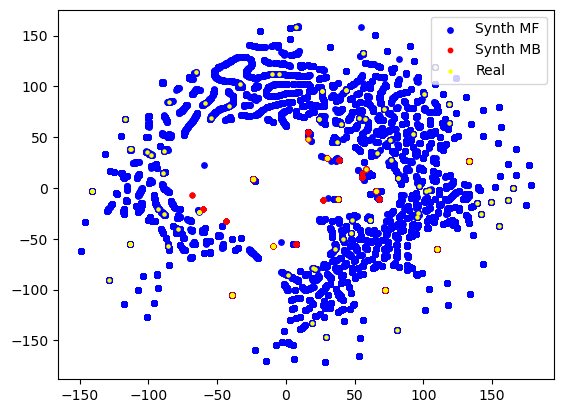

In [74]:
plt.figure()

mf = plt.scatter(X_embedded_mse[:mse_boundary, 0], X_embedded_mse[:mse_boundary, 1], color='blue', s=15)
mb = plt.scatter(X_embedded_mse[mse_boundary:mse_boundary1, 0], X_embedded_mse[mse_boundary:mse_boundary1, 1], color='red', s=10)
real = plt.scatter(X_embedded_mse[mse_boundary1:, 0], X_embedded_mse[mse_boundary1:, 1], color='yellow', s=5)

plt.legend((mf, mb, real), ('Synth MF', 'Synth MB', 'Real'), loc='upper right')

plt.show()

In [75]:
X_embedded_nll = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca').fit_transform(nll_feats.T)
print(X_embedded_nll.shape)

/Users/johnzhou/anaconda3/envs/ssm/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(92211, 2)


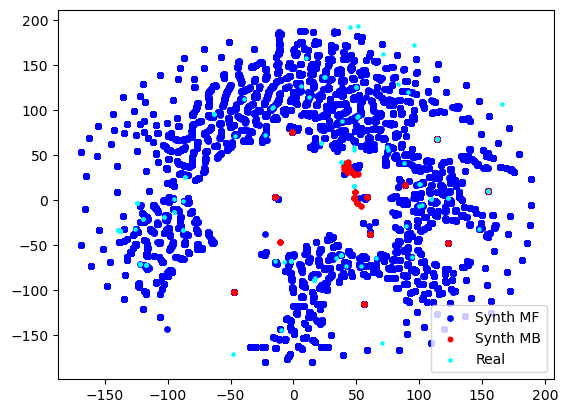

In [78]:
plt.figure()

mf = plt.scatter(X_embedded_nll[:nll_boundary, 0], X_embedded_nll[:nll_boundary, 1], color='blue', s=15)
mb = plt.scatter(X_embedded_nll[nll_boundary:nll_boundary1, 0], X_embedded_nll[nll_boundary:nll_boundary1, 1], color='red', s=10)
real = plt.scatter(X_embedded_nll[nll_boundary1:, 0], X_embedded_nll[nll_boundary1:, 1], color='cyan', s=5)

plt.legend((mf, mb, real), ('Synth MF', 'Synth MB', 'Real'), loc='lower right')

plt.show()

100%|█████████████████████████████████████| 5000/5000 [00:03<00:00, 1304.44it/s]


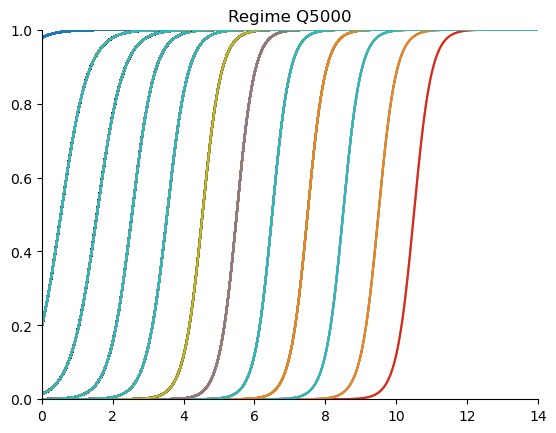

In [43]:
x_bounds = (0, 15)

for i in tqdm(range(5000)):
    params = list(inf_nll[i, :])
    plt.plot(np.linspace(*x_bounds, num=1000),
             epsilon_sigmoid(np.linspace(*x_bounds, num=1000), *params))

ax = plt.gca()
plt.title(f"Regime Q{i + 1}")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([0, 14])
ax.set_ylim([0, 1.0])
plt.show()